In [1]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns
import xarray as xr
from pymc import HalfCauchy, Model, Normal, sample
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy import stats
from category_encoders import OrdinalEncoder, TargetEncoder

In [2]:
df = pd.read_csv('./data/train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
feats = df.columns.to_list()
feats.remove('Id')
feats.remove('SalePrice')

# remove constants
for col in feats.copy():
    if df[col].value_counts(dropna=False).shape[0] == 1:
        feats.remove(col)

target = 'SalePrice'
print(len(feats))

79


In [4]:
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(df[feats], df[target], test_size=test_size, shuffle=True)

In [5]:
df_na = X_train.isna().sum() > 0
X_train[df_na[df_na].index]

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
909,149.0,NaN,NaN,0.0,Gd,TA,No,Unf,Unf,SBrkr,Gd,Attchd,2005.0,Fin,TA,TA,NaN,NaN,NaN
931,70.0,NaN,NaN,0.0,TA,TA,No,BLQ,Rec,SBrkr,NaN,Detchd,1965.0,Unf,TA,TA,NaN,GdWo,NaN
1291,21.0,NaN,BrkFace,268.0,TA,TA,No,ALQ,Unf,SBrkr,NaN,Detchd,1972.0,Unf,TA,TA,NaN,NaN,NaN
470,NaN,NaN,NaN,0.0,Gd,TA,Av,GLQ,BLQ,SBrkr,NaN,Attchd,1985.0,RFn,TA,TA,NaN,NaN,NaN
1143,NaN,NaN,NaN,0.0,TA,TA,No,GLQ,Unf,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,NaN,NaN,NaN,0.0,Gd,Gd,Gd,GLQ,LwQ,SBrkr,NaN,Detchd,1981.0,Unf,TA,Fa,NaN,MnPrv,NaN
53,68.0,NaN,NaN,0.0,Ex,TA,Gd,GLQ,Unf,SBrkr,Gd,Attchd,1981.0,Fin,TA,TA,NaN,NaN,NaN
808,85.0,NaN,BrkFace,1047.0,TA,TA,Av,ALQ,BLQ,SBrkr,Gd,Attchd,1966.0,RFn,TA,TA,NaN,GdWo,NaN
1073,75.0,NaN,BrkFace,140.0,TA,TA,No,BLQ,Unf,SBrkr,NaN,Attchd,1977.0,Fin,TA,TA,NaN,MnPrv,NaN


In [6]:
cat_col_for_fillna = X_train[df_na[df_na].index].select_dtypes(exclude=np.number).columns
cat_cols = X_train.select_dtypes(exclude=np.number).columns

num_col_for_fillna = X_train[df_na[df_na].index].select_dtypes(include=np.number).columns

In [7]:
def cat_col_fillna(df, columns):
    df[columns] = df[columns].fillna('') 
    return df

class NumColComputer(BaseEstimator):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, df, y=None):
        self.means = {}
        for col in self.columns:
            self.means[col] = df[col].mean()
        return self

    def transform(self, df, y=None):
        for col in self.columns:
            df[col] = df[col].fillna(self.means[col])
        return df

preprocessing_pipeline = Pipeline([
    ('cat_fillna', FunctionTransformer(cat_col_fillna, kw_args={'columns': cat_col_for_fillna})),
    ('num_fillna', NumColComputer(columns=num_col_for_fillna)),
    ('encoder', TargetEncoder(cols=cat_cols, min_samples_leaf=40)),
    ('scaler', StandardScaler()),
    
])

In [8]:
X_preprocessed = pd.DataFrame(preprocessing_pipeline.fit_transform(X_train, y_train), columns=feats)
y_train.reset_index(drop=True, inplace=True)

In [9]:
def get_pairs_corr_feats(corr_df, threshold: float) -> list:
    if threshold > 1 or threshold < 0:
        raise ValueError('threshold should be between 0 and 1')

    result = []
    for index, row in corr_df.corr().iterrows():
        curr_corr_cols = row[(row > threshold) | (row < -1 * threshold)].index.tolist()
        curr_corr_cols.remove(index) if index in curr_corr_cols else ...
        for corr_col in curr_corr_cols:
            result.append((index, corr_col, row[corr_col]))

    return result

In [10]:
get_pairs_corr_feats(X_preprocessed, 0.8)

[('Exterior1st', 'Exterior2nd', 0.9556250566267207),
 ('Exterior2nd', 'Exterior1st', 0.9556250566267207),
 ('TotalBsmtSF', '1stFlrSF', 0.8027847974728786),
 ('1stFlrSF', 'TotalBsmtSF', 0.8027847974728786),
 ('GrLivArea', 'TotRmsAbvGrd', 0.8229069966388373),
 ('TotRmsAbvGrd', 'GrLivArea', 0.8229069966388373),
 ('Fireplaces', 'FireplaceQu', 0.8685551504136356),
 ('FireplaceQu', 'Fireplaces', 0.8685551504136356),
 ('GarageCars', 'GarageArea', 0.8871180981266318),
 ('GarageArea', 'GarageCars', 0.8871180981266318),
 ('GarageQual', 'GarageCond', 0.9738748127460923),
 ('GarageCond', 'GarageQual', 0.9738748127460923),
 ('SaleType', 'SaleCondition', 0.9462581585213534),
 ('SaleCondition', 'SaleType', 0.9462581585213534)]

<Axes: >

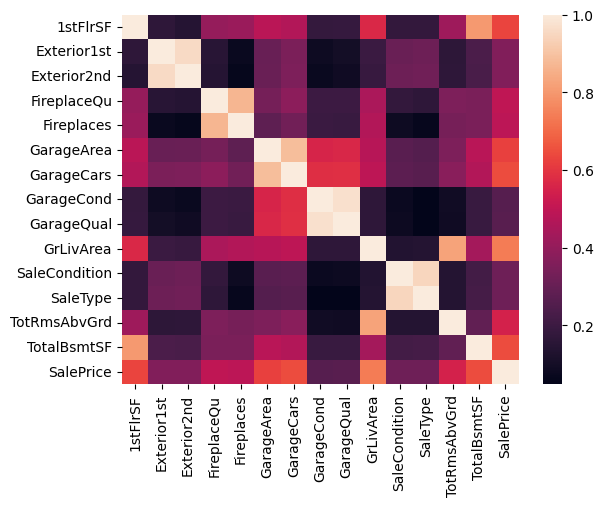

In [11]:
corr_feats = ['1stFlrSF','Exterior1st','Exterior2nd','FireplaceQu','Fireplaces','GarageArea','GarageCars','GarageCond','GarageQual','GrLivArea','SaleCondition','SaleType','TotRmsAbvGrd','TotalBsmtSF']
sns.heatmap(pd.concat([X_preprocessed[corr_feats], y_train], axis=1).corr())

In [12]:
# remove corr feats
for feat in ['Exterior2nd', '1stFlrSF', 'GarageCars','GarageCond', 'TotRmsAbvGrd', 'FireplaceQu', 'SaleCondition', 'PoolQC']:
    if feat in feats:
        feats.remove(feat)
print(f'current number of feats: {len(feats)}')
X_preprocessed = X_preprocessed[feats]

current number of feats: 71


In [13]:
## outliers removing
std_threshold = 3
number_of_cols_threshold = 4

cols_num_beyond_std_thres = ((X_preprocessed > std_threshold) | (X_preprocessed < -std_threshold)).sum(axis=1)
outliers_idx = cols_num_beyond_std_thres[cols_num_beyond_std_thres >= number_of_cols_threshold].index
outliers_idx

Index([   6,   18,   25,   27,   41,   53,   63,   70,   75,   98,
       ...
       1094, 1109, 1114, 1115, 1120, 1129, 1141, 1148, 1164, 1167],
      dtype='int64', length=105)

In [14]:
X_preprocessed = X_preprocessed[~X_preprocessed.index.isin(outliers_idx)]

y_train = pd.DataFrame(y_train)
y_train = y_train[~y_train.index.isin(outliers_idx)]

In [15]:
# feature selection by ANOVA F-test
feature_selector = SelectPercentile(percentile=60)
feature_selector = feature_selector.fit(X_preprocessed, y_train)
feats = list(feature_selector.get_feature_names_out())
X_preprocessed = X_preprocessed[feats]
print(f'current number of feats: {len(feats)}')

current number of feats: 42


/home/zendro/anaconda3/envs/for_bayes/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zendro/anaconda3/envs/for_bayes/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [16]:
target_scaler = StandardScaler()
target_scaler = target_scaler.fit(y_train)
y_train = pd.DataFrame(target_scaler.transform(y_train), columns=[target])

In [17]:
X_preprocessed.reset_index(drop=True, inplace=True)
X_preprocessed

,LotFrontage,LotShape,Utilities,LotConfig,Neighborhood,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageArea,WoodDeckSF,OpenPorchSF,PoolArea,MiscVal,SaleType
0,3.694365,0.973059,0.029273,-0.405344,0.367497,1.386675,-0.075269,1.121079,0.975720,-0.504259,...,0.628776,0.569325,1.104887e+00,1.379072,-0.391957,-0.451901,-0.326763,-0.064914,-0.081884,-0.286909
1,0.002202,-0.757835,0.029273,-0.405344,-0.808002,-0.336199,-0.795882,-0.207573,-0.967070,-0.504259,...,-0.943837,-1.243897,-5.876800e-01,-0.879594,-0.207449,-0.735730,-0.690912,-0.064914,-0.081884,-0.286909
2,-2.287874,-0.757835,0.029273,-0.405344,-0.017930,1.386675,-0.795882,0.024941,-0.627082,-0.504259,...,-0.943837,-1.243897,-2.914807e-01,-0.879594,-0.988057,0.722837,-0.690912,-0.064914,-0.081884,-0.286909
3,0.000000,1.356158,0.029273,0.374363,0.280774,-0.336199,1.365956,0.456753,0.004325,-0.504259,...,-0.943837,0.569325,2.586037e-01,0.464351,0.260916,-0.735730,0.128424,-0.064914,-0.081884,-0.286909
4,0.000000,-0.757835,0.029273,-0.405344,-0.802329,-0.336199,-0.795882,-0.406871,-1.258489,-0.504259,...,-0.943837,-1.907309,-1.924226e-14,-1.695339,-2.237030,-0.735730,-0.326763,-0.064914,-0.081884,-0.286909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,-1.025995,1.356158,0.029273,3.692672,0.150659,-0.336199,-0.075269,0.257455,0.635731,-0.504259,...,0.628776,0.569325,4.718626e-03,-0.879594,-0.179063,0.778026,-0.690912,-0.064914,-0.081884,-0.286909
1059,0.000000,1.356158,0.029273,3.692672,0.367497,1.386675,0.645343,0.988213,0.781441,-0.504259,...,0.628776,1.795006,9.356307e-01,1.379072,-0.183794,0.399587,0.037387,-0.064914,-0.081884,-0.286909
1060,0.000000,1.356158,0.029273,-0.405344,0.419563,-0.730321,-0.075269,0.224238,-0.335664,-0.504259,...,-0.943837,-1.243897,8.934700e-02,-0.879594,0.488001,-0.735730,-0.690912,-0.064914,-0.081884,-0.286909
1061,0.703246,-0.757835,0.029273,-0.405344,-0.808002,-0.730321,-0.795882,-0.174357,-0.918501,-0.504259,...,0.628776,0.569325,-5.453658e-01,0.464351,0.052753,-0.735730,-0.690912,-0.064914,-0.081884,-0.286909


LotFrontage


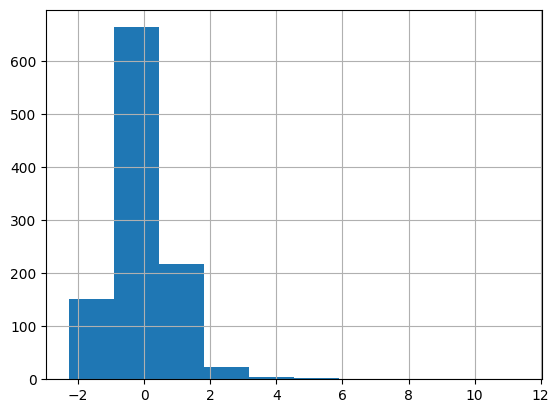

LotShape


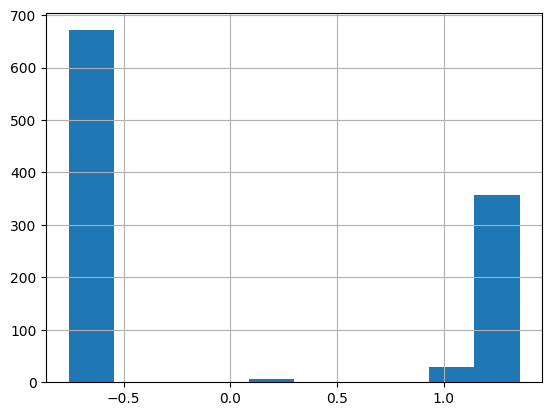

Utilities


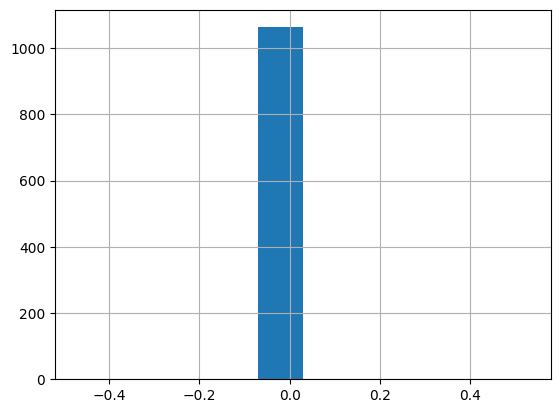

LotConfig


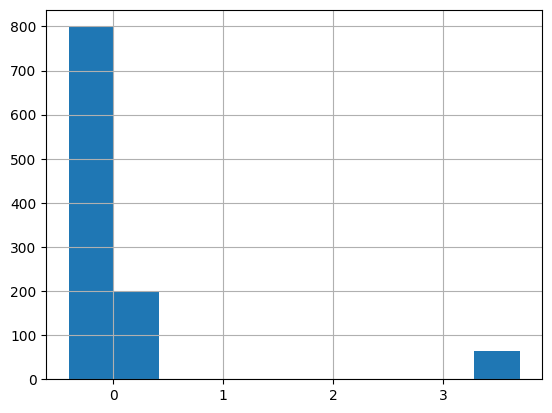

Neighborhood


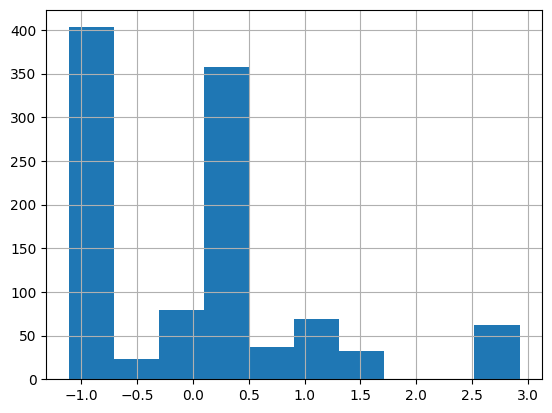

HouseStyle


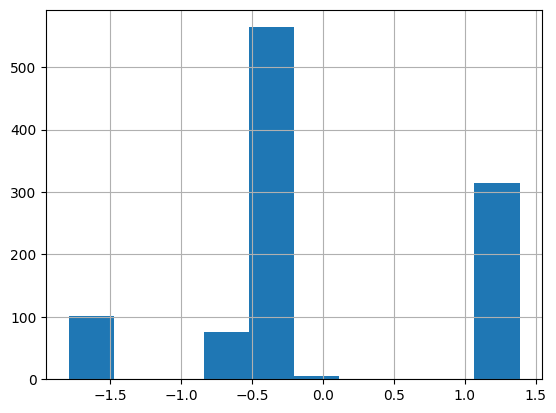

OverallQual


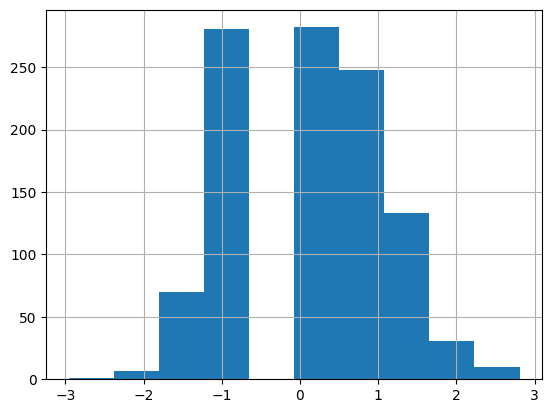

YearBuilt


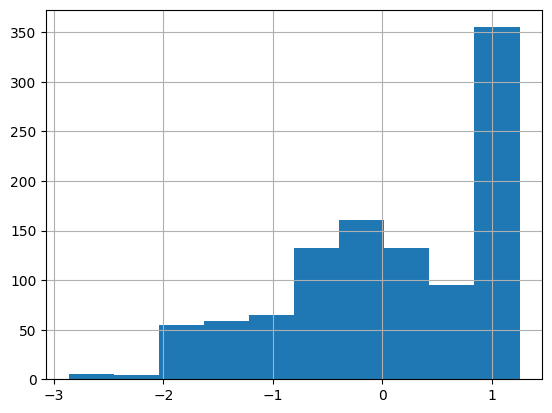

YearRemodAdd


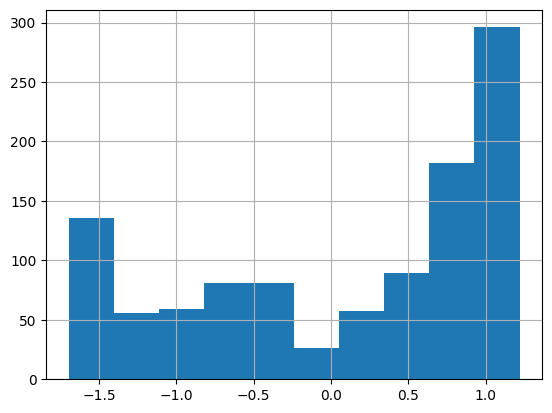

RoofStyle


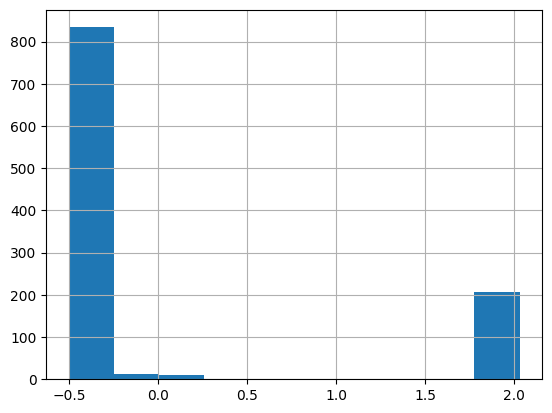

Exterior1st


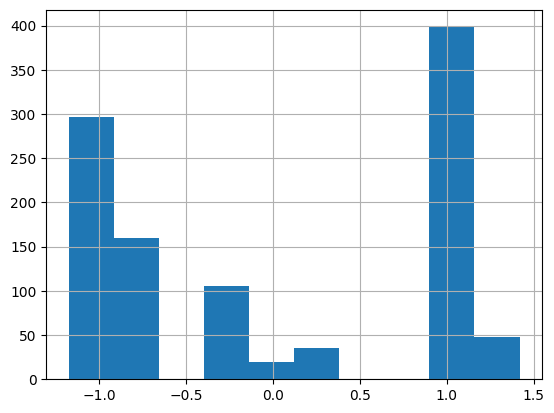

MasVnrType


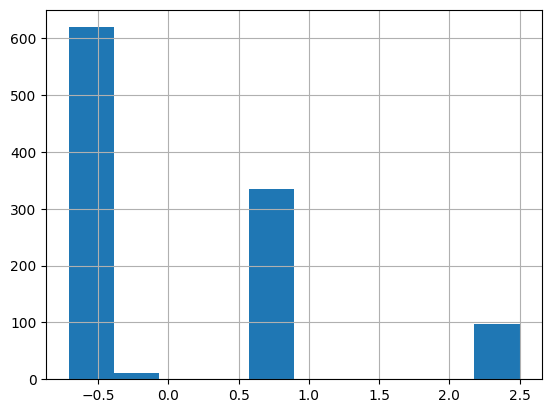

MasVnrArea


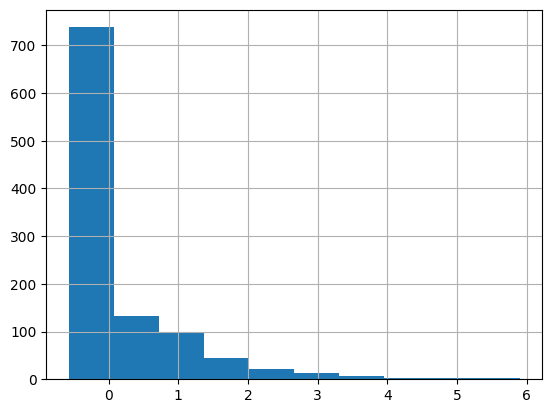

ExterQual


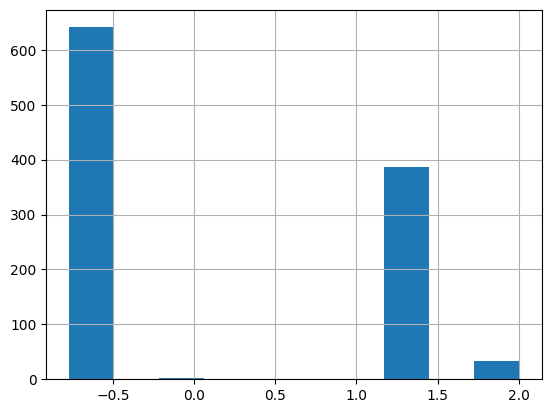

Foundation


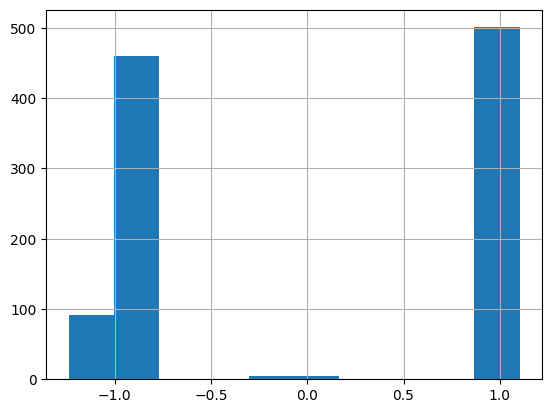

BsmtQual


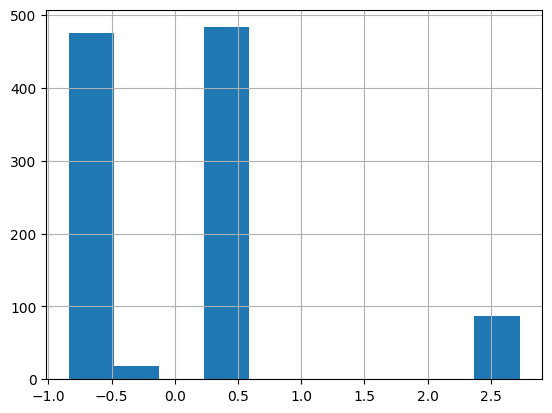

BsmtCond


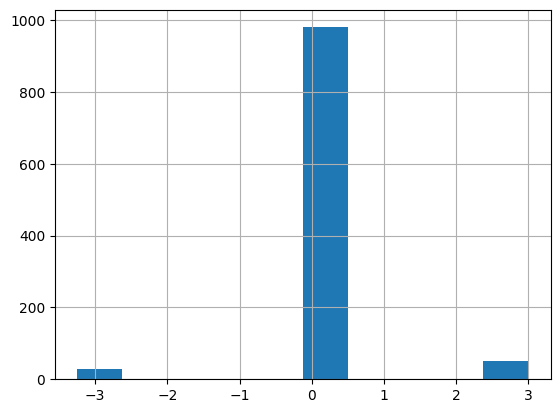

BsmtExposure


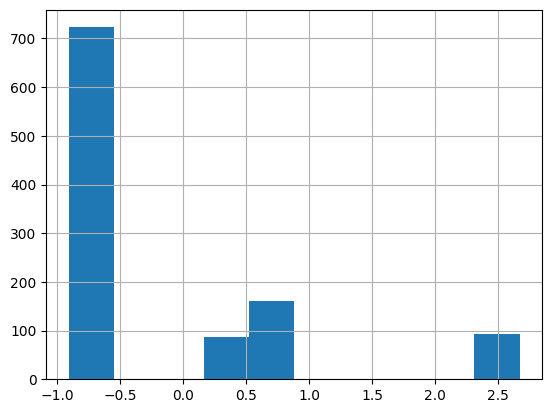

BsmtFinType1


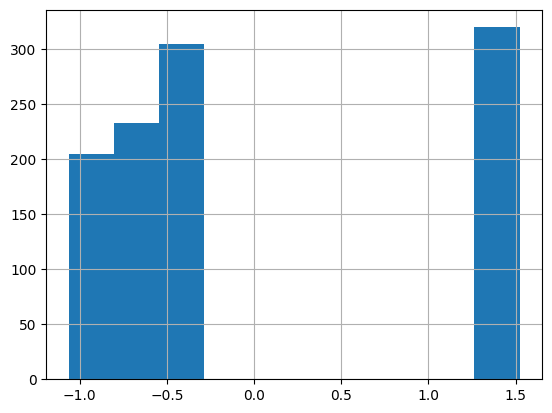

BsmtFinSF1


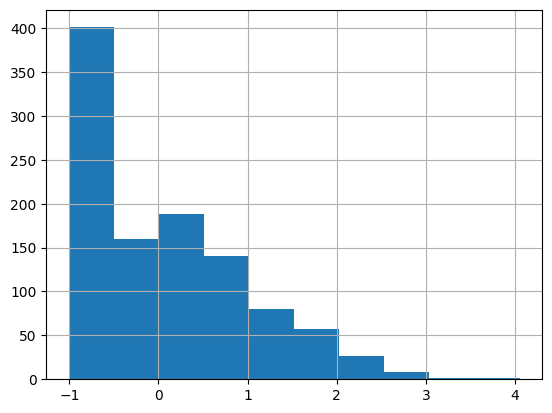

BsmtUnfSF


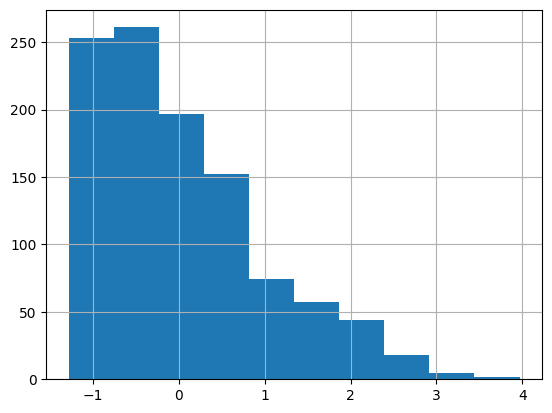

TotalBsmtSF


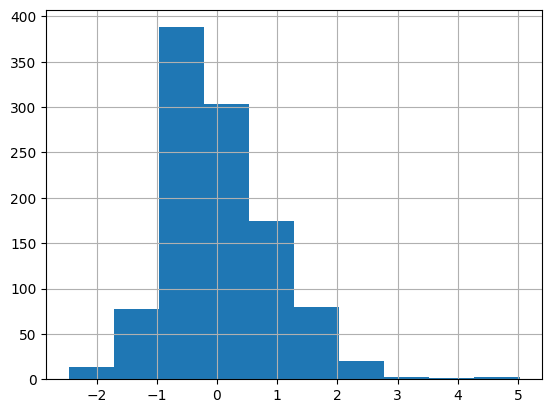

Heating


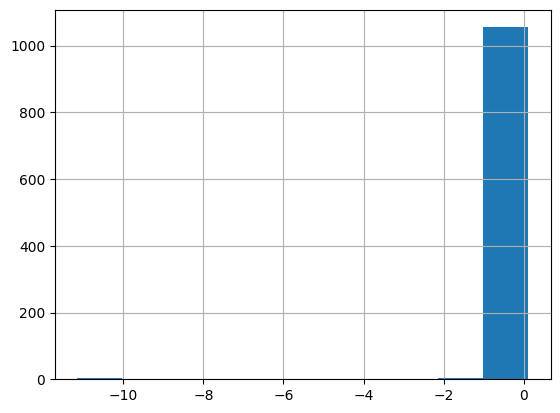

HeatingQC


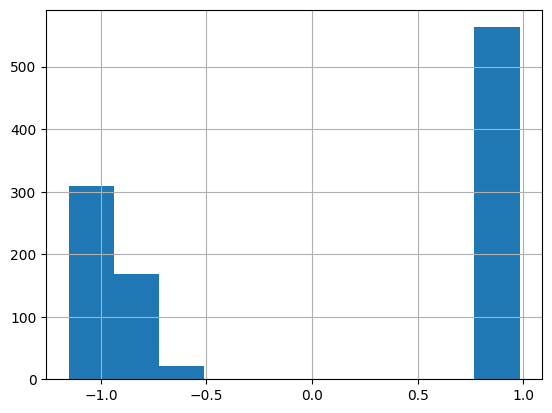

CentralAir


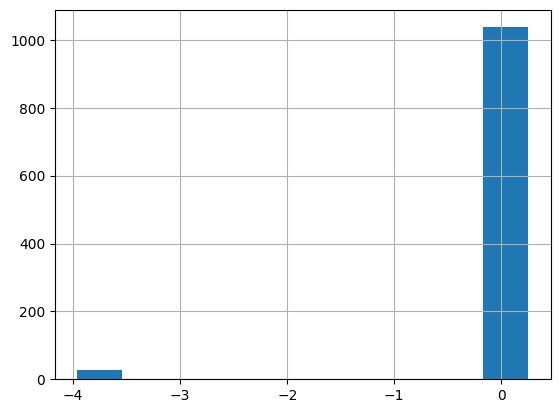

2ndFlrSF


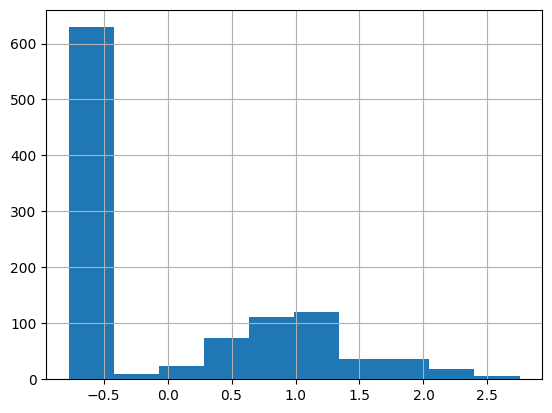

GrLivArea


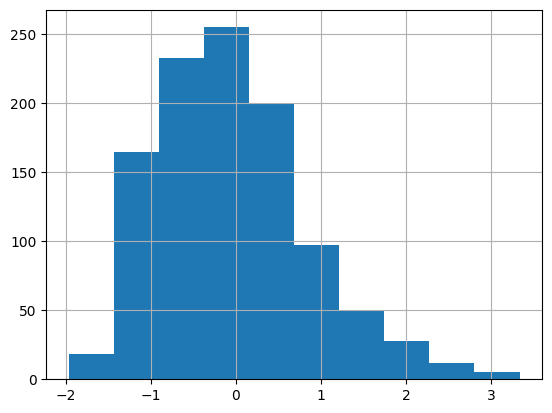

FullBath


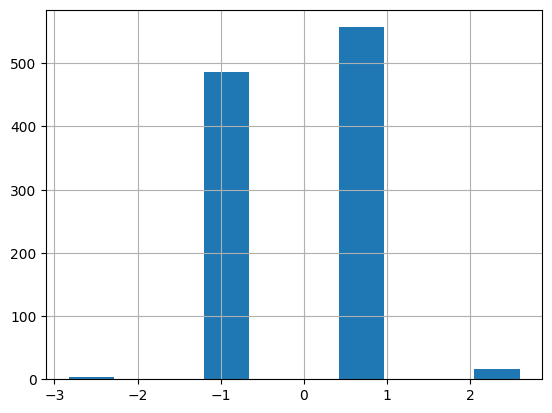

HalfBath


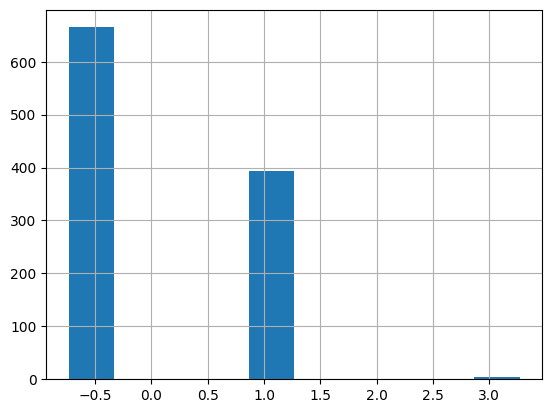

BedroomAbvGr


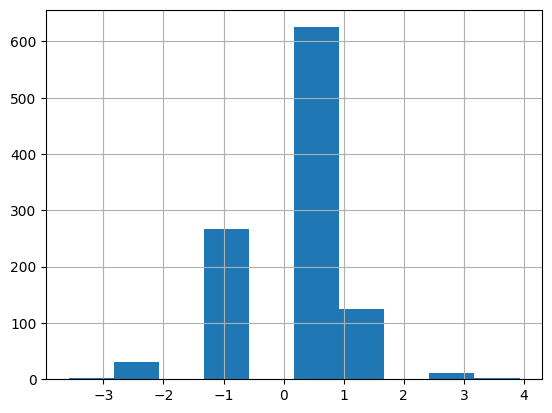

KitchenAbvGr


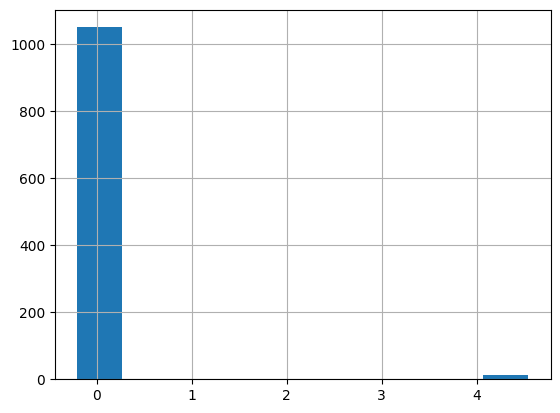

KitchenQual


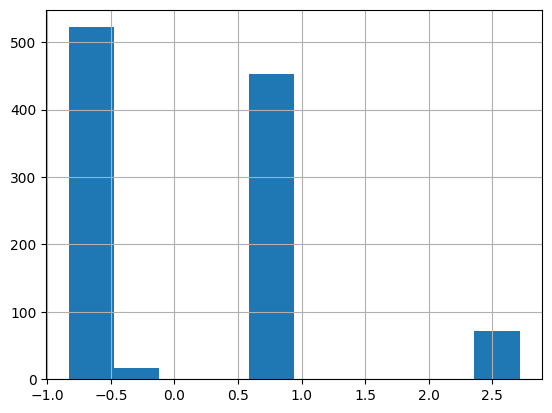

Fireplaces


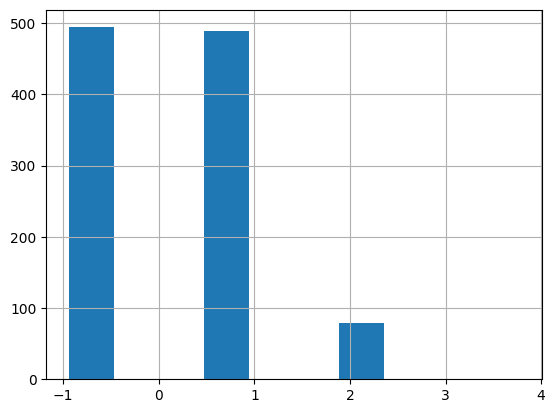

GarageType


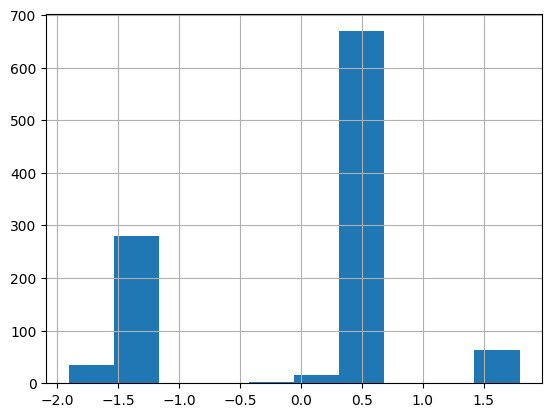

GarageYrBlt


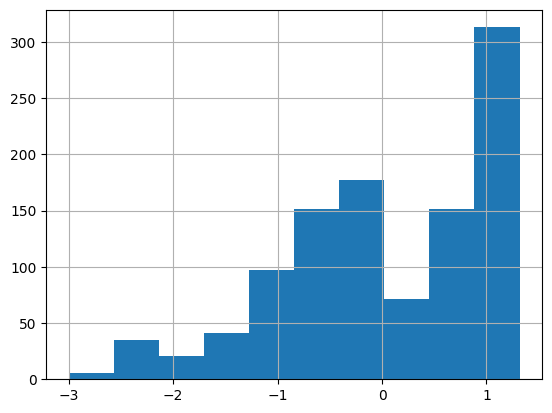

GarageFinish


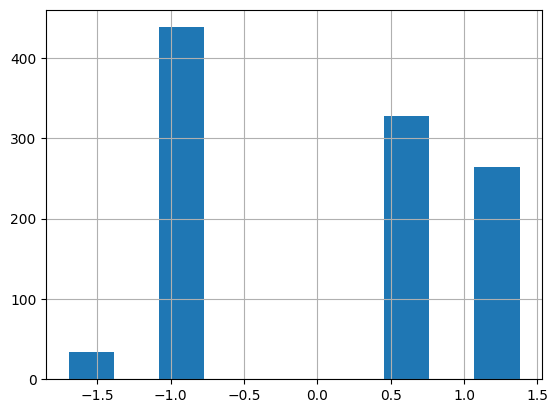

GarageArea


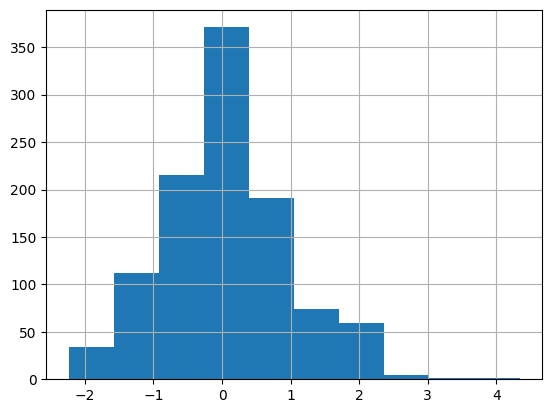

WoodDeckSF


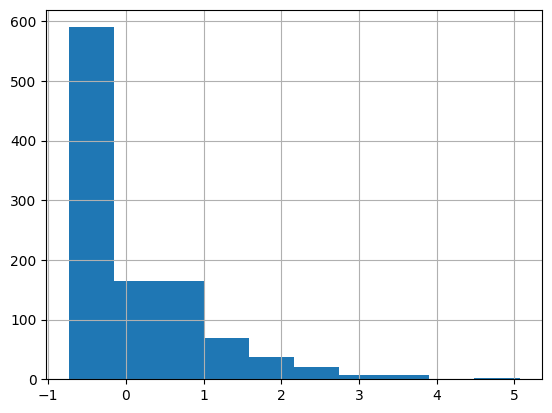

OpenPorchSF


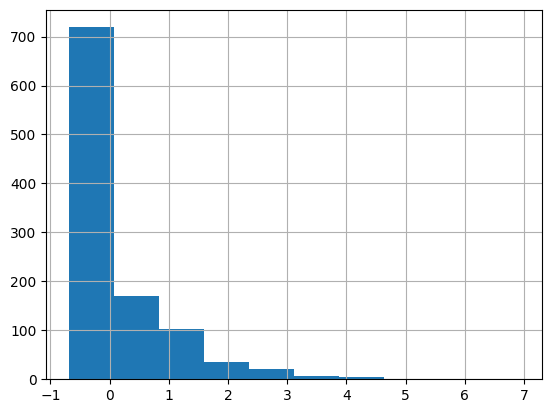

PoolArea


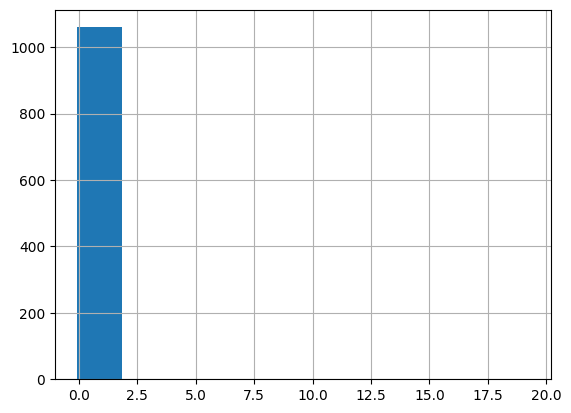

MiscVal


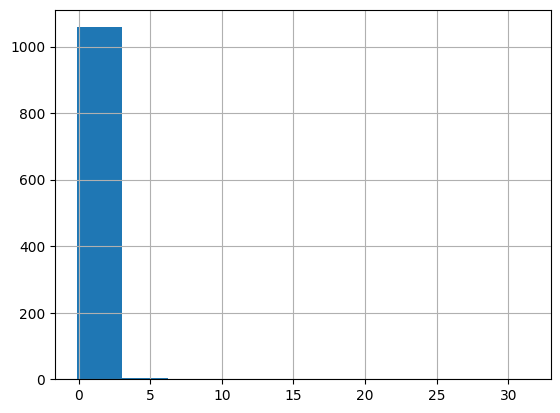

SaleType


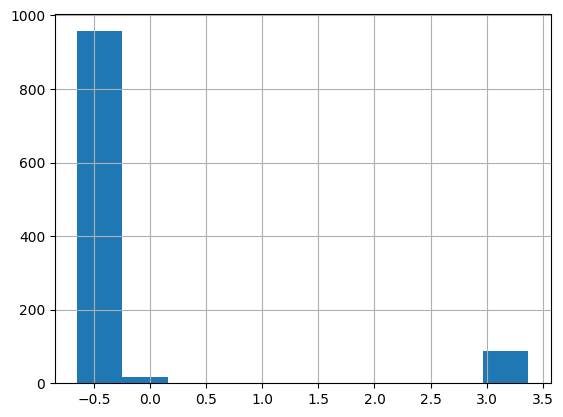

In [18]:
for col in feats:
    print(col)
    X_preprocessed[col].hist()
    plt.show()

## model

In [19]:
%%time
coords = {"observation": X_preprocessed.index.values}

with Model(coords=coords) as model:
    # Define priors
    sigma = HalfCauchy("sigma", beta=1)
    # intercept = Normal("intercept", 0, sigma=1)
    
    dict_of_slopes = {f'{col}_slope': Normal(f"{col}_slope", 0, sigma=1) for col in feats}
    dict_of_data = {f'{col}_data': pm.ConstantData(col, X_preprocessed[col].to_numpy()) for col in feats}

    # Define likelihood
    mu = Normal("intercept", 0, sigma=1)  # intercent firstly
    for col in X_preprocessed.columns:
        mu += dict_of_slopes[f'{col}_slope'] * dict_of_data[f'{col}_data']

    likelihood = Normal("y", mu=mu, sigma=sigma, observed=y_train[target])

    trace = sample(3000, chains=2, cores=8)
    prediction = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [sigma, LotFrontage_slope, LotShape_slope, Utilities_slope, LotConfig_slope, Neighborhood_slope, HouseStyle_slope, OverallQual_slope, YearBuilt_slope, YearRemodAdd_slope, RoofStyle_slope, Exterior1st_slope, MasVnrType_slope, MasVnrArea_slope, ExterQual_slope, Foundation_slope, BsmtQual_slope, BsmtCond_slope, BsmtExposure_slope, BsmtFinType1_slope, BsmtFinSF1_slope, BsmtUnfSF_slope, TotalBsmtSF_slope, Heating_slope, HeatingQC_slope, CentralAir_slope, 2ndFlrSF_slope, GrLivArea_slope, FullBath_slope, HalfBath_slope, BedroomAbvGr_slope, KitchenAbvGr_slope, KitchenQual_slope, Fireplaces_slope, GarageType_slope, GarageYrBlt_slope, GarageFinish_slope, GarageArea_slope, WoodDeckSF_slope, OpenPorchSF_slope, PoolArea_slope, MiscVal_slope, SaleType_slope, intercept]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 82 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


CPU times: user 26.8 s, sys: 684 ms, total: 27.5 s
Wall time: 2min 15s


In [20]:
preds = prediction.posterior_predictive['y'].mean(dim='draw').mean(dim='chain').to_dataframe()
preds = target_scaler.inverse_transform(preds)
preds = pd.Series(preds.reshape(len(preds)))
preds.name = 'preds'

y_true = target_scaler.inverse_transform(y_train)
y_true = pd.Series(y_true.reshape(len(y_true)))
y_true.name = target

In [21]:
inferences_bayes = pd.concat([y_true, preds], axis=1)

In [22]:
#az.plot_trace(trace, figsize=(10, 7))

In [23]:
with model:
    # compute maximum a-posteriori estimate
    # for logistic regression weights
    manual_map_estimate = pm.find_MAP()
print('weights for regression')
pd.Series({k: np.asscalar(v) for k, v in manual_map_estimate.items()})


weights for regression


/tmp/ipykernel_5602/1904368914.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  pd.Series({k: np.asscalar(v) for k, v in manual_map_estimate.items()})


sigma_log__          -1.104150
LotFrontage_slope     0.065595
LotShape_slope        0.015290
Utilities_slope      -0.001033
LotConfig_slope       0.028029
Neighborhood_slope    0.116875
HouseStyle_slope     -0.008734
OverallQual_slope     0.203709
YearBuilt_slope      -0.012548
YearRemodAdd_slope    0.040408
RoofStyle_slope       0.028528
Exterior1st_slope     0.033655
MasVnrType_slope     -0.008043
MasVnrArea_slope      0.035940
ExterQual_slope       0.020629
Foundation_slope     -0.006233
BsmtQual_slope        0.069974
BsmtCond_slope        0.024154
BsmtExposure_slope    0.078632
BsmtFinType1_slope    0.007191
BsmtFinSF1_slope      0.081077
BsmtUnfSF_slope      -0.042676
TotalBsmtSF_slope     0.173941
Heating_slope        -0.004163
HeatingQC_slope       0.014536
CentralAir_slope      0.022034
2ndFlrSF_slope        0.040944
GrLivArea_slope       0.334695
FullBath_slope       -0.019889
HalfBath_slope        0.005358
BedroomAbvGr_slope   -0.009838
KitchenAbvGr_slope   -0.078544
KitchenQ

In [24]:
lr = LinearRegression()
lr.fit(X_preprocessed, y_true)
lr_pred = lr.predict(X_preprocessed)

In [25]:
inferences_classical = pd.concat([y_true, pd.Series(lr_pred.reshape(len(lr_pred)))], axis=1).\
                       rename(columns={0: 'preds'})
inferences_classical

,SalePrice,preds
0,174000.0,185231.212236
1,117500.0,111682.633917
2,119500.0,113501.766471
3,212000.0,227007.677112
4,80000.0,93982.729870
...,...,...
1058,181000.0,164191.943786
1059,222500.0,222974.909712
1060,147000.0,170187.869427
1061,159950.0,150285.661297


In [26]:
print(f"classical approach loss: {mean_squared_error(inferences_classical[target], inferences_classical['preds'])}")
print(f"bayes approach loss: {mean_squared_error(inferences_bayes[target], inferences_bayes['preds'])}")
print(f"difference loss: {mean_squared_error(inferences_bayes[target], inferences_bayes['preds']) - mean_squared_error(inferences_classical[target], inferences_classical['preds'])}")

classical approach loss: 583093916.6999468
bayes approach loss: 582912170.208532
difference loss: -181746.49141478539
